In [ ]:
! sudo pip3 install dgl-cu101

     |████████████████████████████████| 36.2MB 76kB/s 


In [ ]:
! nvidia-smi

Sun Jun 20 00:13:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! sudo pip3 install dglke

     |████████████████████████████████| 81kB 5.0MB/s 


In [ ]:
! git clone https://github.com/gnn4dr/DRKG.git

Cloning into 'DRKG'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 283 (delta 48), reused 81 (delta 45), pack-reused 188
Receiving objects: 100% (283/283), 1.39 MiB | 18.67 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [ ]:
import pandas as pd
import numpy as np
import dgl
import sys
sys.path.insert(1, 'DRKG/utils')
from utils import download_and_extract
download_and_extract()
drkg_file = '../data/drkg.tsv'
df = pd.read_csv(drkg_file, sep="\t")
triplets = df.values.tolist()

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


Download finished. Unzipping the file...


In [ ]:
! wget https://dgl-data.s3-us-west-2.amazonaws.com/dataset/DRKG/drkg.tar.gz


--2021-06-20 00:18:02--  https://dgl-data.s3-us-west-2.amazonaws.com/dataset/DRKG/drkg.tar.gz
Resolving dgl-data.s3-us-west-2.amazonaws.com (dgl-data.s3-us-west-2.amazonaws.com)... 52.218.225.73
Connecting to dgl-data.s3-us-west-2.amazonaws.com (dgl-data.s3-us-west-2.amazonaws.com)|52.218.225.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216650245 (207M) [application/x-tar]
Saving to: ‘drkg.tar.gz’

drkg.tar.gz         100%[===================>] 206.61M  33.0MB/s    in 6.2s    

2021-06-20 00:18:09 (33.2 MB/s) - ‘drkg.tar.gz’ saved [216650245/216650245]



In [ ]:
! tar -xf drkg.tar.gz

In [ ]:
! ls embed/

DRKG_TransE_l2_entity.npy    mol_contextpred.npy  mol_masking.npy
DRKG_TransE_l2_relation.npy  mol_edgepred.npy	  Readme.md
entities.tsv		     mol_infomax.npy	  relations.tsv


In [ ]:
! ls  DRKG/

connectivity.png  drug_repurpose      licenses		  utils
drkg_with_dgl	  embedding_analysis  raw_graph_analysis
drugbank_info	  LICENSE	      Readme.md


In [ ]:
! ls

DRKG	     drkg.tsv  entity2src.tsv	      sample_data
drkg.tar.gz  embed     relation_glossary.tsv


In [ ]:
print(len(triplets))

5874260


In [ ]:
import pandas as pd
import numpy as np
import os
import csv


rel2id = {}
id2rel = {}
with open("./embed/relations.tsv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['rel','id'])
    for row_val in reader:
        id = row_val['id']
        relation = row_val['rel']

        rel2id[relation] = int(id)
        id2rel[int(id)] = relation

print("Number of relations: {}".format(len(rel2id)))

Number of relations: 107


In [ ]:
rel_emb = np.load('./embed/DRKG_TransE_l2_relation.npy')
print(rel_emb.shape)

(107, 400)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


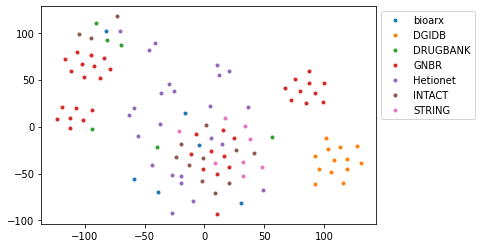

In [ ]:

from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

dataset_id = {}
for rel_name, i in rel2id.items():
    rel_key = rel_name.split('::')[0]
    if dataset_id.get(rel_key, None) is None:
        dataset_id[rel_key] = []
    dataset_id[rel_key].append(i)

X_embedded = TSNE(n_components=2).fit_transform(rel_emb).T
p = cm.rainbow(int(255/2 * 1))
fig = plt.figure()
ax = fig.add_subplot(111)
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=np.long)

    ax.plot(X_embedded[0][val], X_embedded[1][val], '.', label=key)

lgd = ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig('relation.eps', bbox_extra_artists=(lgd,), bbox_inches='tight', format='eps')

In [ ]:
from google.colab import files

files.download('edge_pair_jaccard_scores_sorted_jacard.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(rel_emb)
idx = np.flip(np.argsort(similarity), axis=1)

max_pairs = []
for i in range(idx.shape[0]):
    j = 1
    while (similarity[i][idx[i][j]] > 0.9):
        max_pairs.append((id2rel[idx[i][0]], id2rel[idx[i][j]], similarity[i][idx[i][j]]))
        j += 1

def sort_score(pair):
    return pair[2]

max_pairs.sort(reverse=True, key=sort_score)
sim_pairs = []
for i, pair in enumerate(max_pairs):
    if i % 2 == 0:
        sim_pairs.append(pair)

sim_pairs[:10]

[('GNBR::E::Compound:Gene', 'GNBR::K::Compound:Gene', 0.9859934),
 ('GNBR::E::Compound:Gene', 'GNBR::E+::Compound:Gene', 0.98297095),
 ('GNBR::N::Compound:Gene', 'GNBR::E-::Compound:Gene', 0.9698722),
 ('GNBR::E::Compound:Gene', 'GNBR::E-::Compound:Gene', 0.96532136),
 ('GNBR::K::Compound:Gene', 'GNBR::E+::Compound:Gene', 0.9564863),
 ('GNBR::E+::Compound:Gene', 'GNBR::E-::Compound:Gene', 0.95019233),
 ('GNBR::L::Gene:Disease', 'GNBR::G::Gene:Disease', 0.94194484),
 ('GNBR::K::Compound:Gene', 'GNBR::E-::Compound:Gene', 0.94074607),
 ('GNBR::J::Gene:Disease', 'GNBR::Md::Gene:Disease', 0.9319676),
 ('GNBR::J::Gene:Disease', 'GNBR::Te::Gene:Disease', 0.9318372)]

(11449,)


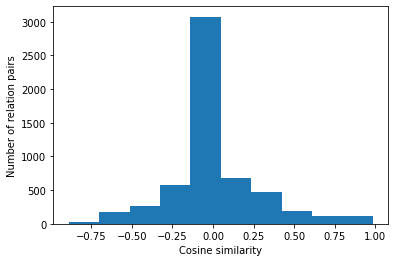

In [ ]:
similarity=similarity.flatten()
print(similarity.shape)

# cleanup self-compare and dup-compare
s = similarity < 0.99
s = np.unique(similarity[s])
plt.xlabel('Cosine similarity')
plt.ylabel('Number of relation pairs')
plt.hist(s)
plt.savefig('relation-sim.eps', format='eps')

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

similarity = euclidean_distances(rel_emb)
idx = np.argsort(similarity)

min_pairs = []
for i in range(idx.shape[0]):
    j = 1
    while (similarity[i][idx[i][j]] < 5):
        min_pairs.append((id2rel[idx[i][0]], id2rel[idx[i][j]], similarity[i][idx[i][j]]))
        j += 1

def sort_score(pair):
    return pair[2]

min_pairs.sort(key=sort_score)
sim_pairs = []
for i, pair in enumerate(min_pairs):
    if i % 2 == 0:
        sim_pairs.append(pair)

sim_pairs[:10]

[('GNBR::E::Compound:Gene', 'GNBR::K::Compound:Gene', 1.6984596),
 ('GNBR::E::Compound:Gene', 'GNBR::E+::Compound:Gene', 1.8601348),
 ('GNBR::N::Compound:Gene', 'GNBR::E-::Compound:Gene', 2.3698092),
 ('GNBR::E::Compound:Gene', 'GNBR::E-::Compound:Gene', 2.606229),
 ('GNBR::K::Compound:Gene', 'GNBR::E+::Compound:Gene', 2.9946468),
 ('GNBR::E+::Compound:Gene', 'GNBR::E-::Compound:Gene', 3.1560013),
 ('GNBR::L::Gene:Disease', 'GNBR::G::Gene:Disease', 3.4119256),
 ('GNBR::K::Compound:Gene', 'GNBR::E-::Compound:Gene', 3.454293),
 ('GNBR::J::Gene:Disease', 'GNBR::Md::Gene:Disease', 3.6071572),
 ('GNBR::J::Gene:Disease', 'GNBR::Te::Gene:Disease', 3.624401)]

(11449,)


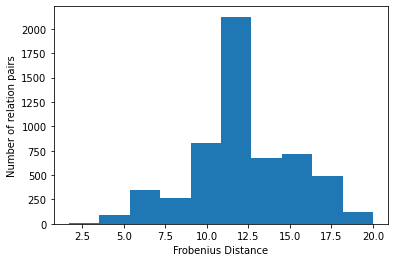

In [ ]:
similarity=similarity.flatten()
print(similarity.shape)

# cleanup self-compare and dup-compare
s = similarity > 0
s = np.unique(similarity[s])
plt.xlabel('Frobenius Distance')
plt.ylabel('Number of relation pairs')
plt.hist(s)
plt.show()

In [ ]:
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

